# Rodeo algorithm in qiskit runtime

## March 2023

### To do next:
- Add noise models
- More scrambling of $t$ values
- Allow more interesting pauli hamiltonians

In [1]:
import numpy as np
from numpy.random import randn
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_ibm_runtime import Sampler
from qiskit.circuit import Parameter, Gate
from qiskit.opflow import I, X, Y, Z, PauliOp, MatrixEvolution, MatrixOp
from qiskit.quantum_info import Operator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.tools.visualization import plot_histogram
import matplotlib.pyplot as plt

In [2]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_qasm_simulator")

In [3]:
def zsum(t: Parameter, nqubits, coeffs):
    """ Creates time evolution operator for non-interacting qubits. Default is Z.
    """
    circ = QuantumCircuit(nqubits)
    for q in range(nqubits):
        circ.rz(2 * t*coeffs[q], q) 
        
    return circ.to_gate(label = 'RZs')

def rodeo_cycle(U, t:Parameter, targ:Parameter, sysqubits:int, coeffs):
    """Prepares a unitary quantum gate for a single cycle of the rodeo algorithm
    without measurements. Contains the parameters t and targ.
    """
    # Prepare registers
    aux = QuantumRegister(1,'a')
    sys = QuantumRegister(sysqubits, 's')
    circuit = QuantumCircuit(aux, sys)
    
    # Add Hadamard test gates
    circuit.h(aux)
    circuit.append(U(t, sysqubits, coeffs).control(1), range(1+sysqubits))
    circuit.p(targ * t,aux)
    circuit.h(aux)
    return circuit.to_gate(label=r'$R_{cyc}$')

In [42]:
# Parameters
cycles = 6
sys_size = 1
targ = Parameter(r'$E_\odot$')
t = [Parameter(fr'$t_{i}$') for i in range(cycles)]

In [43]:
# Create registers and initialize circuit
cbits = ClassicalRegister(cycles, 'c')
aux = QuantumRegister(1, 'a')
sys = QuantumRegister(sys_size, 's')
circ = QuantumCircuit(cbits, aux, sys)

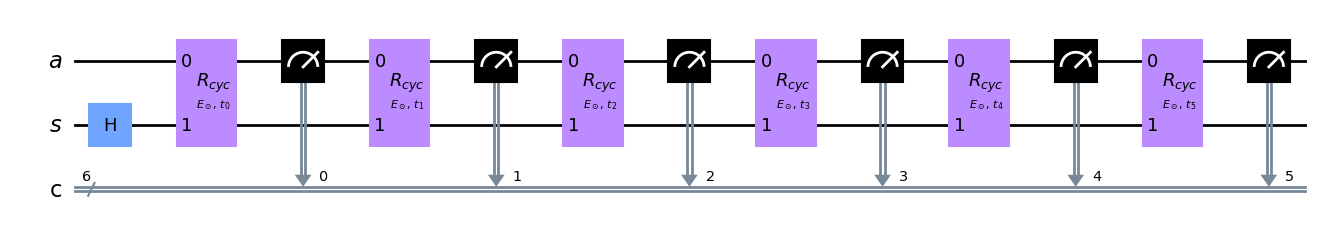

In [44]:
# Hamiltonian parameters
coeffs = [1]*sys_size

# State prep
circ.h(sys)

# Iteratively construct full rodeo circuit
for cyc in range(cycles):
    circ.append(rodeo_cycle(zsum, t[cyc], targ, sys_size, coeffs), range(1 + sys_size))
    circ.measure(aux, cbits[cyc])
circ.draw(output= 'mpl')

## Do a Rodeo scan

This will scan over target energies, using randomly sampled $t$ for number of cycles, then repeating these *same* $t$ for each shot. Later will try to get more randomized $t$ samples.

In [60]:
energymax = 2
energymin = -2
stepsize = .1

targetenergies = np.linspace(energymin, energymax, int((energymax-energymin)/stepsize))

# Energy window, which should to be slightly larger than stepsize in scan
# Is inverse of sigma paramter
gamma = .3

params = []
for i, energy in enumerate(targetenergies):
    tsamples = list(1/gamma * randn(cycles))
    params = params + [[targetenergies[i]] + tsamples]
runs = len(params)

# Execute circuit with bound parameters
sampler = Sampler(session=backend)
job = sampler.run([circ]*runs, params, shots = 1024)
result = job.result()
probs = result.quasi_dists

# Extract all-zero normalized counts
allzeroprob = [0]*len(probs)

for i, dist in enumerate(probs):
    try:
        allzeroprob[i] = probs[i][0]
    except KeyError:
        allzeroprob[i] = 0

Text(0.5, 1.0, 'Rodeo scan with $\\Gamma = 0.3$')

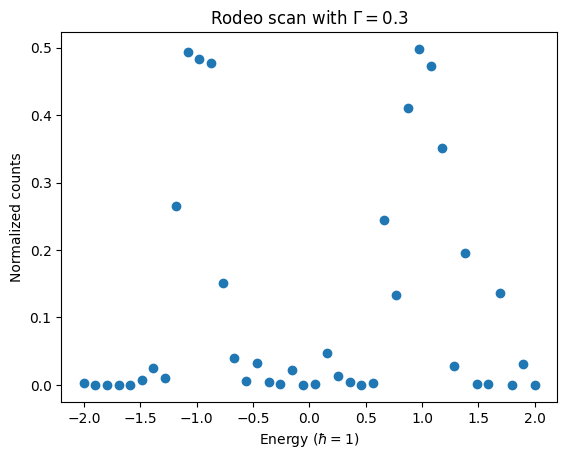

In [68]:
# Plot results
plt.plot(targetenergies, allzeroprob, linestyle = "None",marker = 'o')
plt.ylabel("Normalized counts")
plt.xlabel(r"Energy ($\hbar = 1$)")
plt.title(r"Rodeo scan with $\Gamma = {}$".format(gamma))

In [ ]:
aux = QuantumRegister(1,'a')
sys = QuantumRegister(U.width(), 's')
circuit = QuantumCircuit(2)
circuit.x(0)
circuit = circuit.compose(U,qubits = [1])
circuit.draw()

In [ ]:
U = QuantumCircuit(3)
U = U.to_gate()
circ = QuantumCircuit(3)
circ.append(U, qargs = [0,1,2])

In [ ]:
exact_evo.parameters

In [ ]:
t = Parameter('t')
targ = Parameter('E')
circ = rodeo_cycle(zsum, t, targ, 1, [1]).draw(output = 'mpl')
circrun = circ.bind_parameters([

In [ ]:
sysqubits = 1
coeffs = [1]
t = Parameter('t')
targ = Parameter('E')
# Prepare registers
cbits = ClassicalRegister(1)
aux = QuantumRegister(1,'a')
sys = QuantumRegister(sysqubits, 's')
circuit = QuantumCircuit(cbits,aux, sys)

# Add Hadamard test gates
circuit.h(aux)
circuit.
circuit.p(targ * t,aux)
circuit.h(aux)
circuit.measure(aux,cbits)



circrun.draw()